### Hackathon 3: Optimisation of a Bioprocess with Multifidelity Bayesian Optimisation

In [8]:
import numpy as np
import torch
import gpytorch
#import plotly.graph_objs as go
from scipy.optimize import minimize
import virtual_lab as vl
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
from sklearn.decomposition import PCA
import conditions_data as data
from scipy.optimize import NonlinearConstraint
from utils import standardize_data, unstandardize_y, train_gp_model, \
    expected_improvement, summed_feeding, optimize_acquisition_function, plot_data

In [9]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy.integrate import quad
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
import math
import time
import sobol_seq

class GP_model_meanzero:

    def __init__(self, X, Y, kernel, hyperparams_multistart_loops):
        self.X, self.Y, self.kernel = X, Y, kernel
        self.number_of_point, self.nx_dimensions, self.ny_dimensions = X.shape[0], X.shape[1], Y.shape[1]
        self.multistart_loops            = hyperparams_multistart_loops

        #Normalisation
        self.X_mean, self.X_std     = np.mean(X, axis=0), np.std(X, axis=0)
        self.Y_mean, self.Y_std     = np.mean(Y, axis=0), np.std(Y, axis=0)
        self.X_norm, self.Y_norm    = (X-self.X_mean)/self.X_std, (Y-self.Y_mean)/self.Y_std

        #Determine Kernel Hyperparameters 
        self.hyperparam_optimized , self.inverse_covariance_matrix_opt   = self.determine_hyperparameters()     
        
    def Cov_mat(self, kernel, X_norm, W, sf2):
        if kernel == 'SquaredExponential':
            xixj_euclidean_distance = cdist(X_norm, X_norm, 'seuclidean', V=W)**2 
            cov_matrix = sf2*np.exp(-0.5*xixj_euclidean_distance)
            return (cov_matrix)
        else:
            print('ERROR no kernel with name ', kernel)


    def negative_loglikelihood(self, hyper, X, Y):
        # internal parameters
        n_point, nx_dim = self.number_of_point, self.nx_dimensions
        kernel          = self.kernel
         
        W               = np.exp(2*hyper[:nx_dim])   # W <=> 1/lambda
        sf2             = np.exp(2*hyper[nx_dim])    # variance of the signal 
        sn2             = np.exp(2*hyper[nx_dim+1])  # variance of noise

        # obtaining negative logliklihood via Cholesky decomposition 
        K       = self.Cov_mat(kernel, X, W, sf2)  
        K       = K + (sn2 + 1e-8)*np.eye(n_point) 
        K       = (K + K.T)*0.5                   
        L       = np.linalg.cholesky(K)            
        logdetK = 2 * np.sum(np.log(np.diag(L)))   
        invLY   = np.linalg.solve(L,Y)             
        alpha   = np.linalg.solve(L.T,invLY)       
        NLL     = np.dot(Y.T,alpha) + logdetK     
        return (NLL)

    
    def determine_hyperparameters(self): 
        # setting up bounds for the log likelyhood minimsation
        lower_bound = np.array([-4.]*(self.nx_dimensions+1) + [-8.])  # lengthscales + signal variance, noise variance
        upper_bound = np.array([4.]*(self.nx_dimensions+1) + [ -2.]) 
        bounds      = np.hstack((lower_bound.reshape(self.nx_dimensions+2,1), upper_bound.reshape(self.nx_dimensions+2,1)))

        #gives number of input set of random starting guesses for each hyperparameter
        multi_startvec         = sobol_seq.i4_sobol_generate(self.nx_dimensions + 2, self.multistart_loops)
        
        #variables for storing information during loop
        temp_min_hyperparams   = [0.]*self.multistart_loops
        temp_loglikelihood     = np.zeros((self.multistart_loops))
        hyperparam_optimized   = np.zeros((self.nx_dimensions+2, self.ny_dimensions)) #for best solutions
        inverse_covariance_matrix_opt = []
        
        #minimisation of hyperparameters
        for i in range(self.ny_dimensions):
            for j in range(self.multistart_loops ):
                #initilising hyperparam guess
                hyperparams_initialisation   = lower_bound + (upper_bound-lower_bound)*multi_startvec[j,:] # mapping sobol unit cube to boudns
               
                result = minimize(self.negative_loglikelihood,
                               hyperparams_initialisation,
                               args=(self.X_norm, self.Y_norm[:,i]),
                               method='SLSQP',
                               options={'disp':False,'maxiter':10000},
                               bounds=bounds,
                               tol=1e-12)
                
                temp_min_hyperparams[j] = result.x
                temp_loglikelihood[j]   = result.fun  

            # choosing best solution from temporary lists
            minimumloglikelihood_index    = np.argmin(temp_loglikelihood)
            hyperparam_optimized[:,i]     = temp_min_hyperparams[minimumloglikelihood_index  ]
    
            # exponential to recover value from log space
            lengthscale_opt         = np.exp(2.*hyperparam_optimized[:self.nx_dimensions,i])
            signalvarience_opt      = np.exp(2.*hyperparam_optimized[self.nx_dimensions,i])
            noise_opt               = np.exp(2.*hyperparam_optimized[self.nx_dimensions+1,i]) + 1e-8
    
            #obtain convarience matrix from optimised kernel hyper parameters
            covarience_matrix_opt              = self.Cov_mat(self.kernel, self.X_norm, lengthscale_opt,signalvarience_opt) + noise_opt*np.eye(self.number_of_point)
            self.covarience_matrix_opt         = covarience_matrix_opt
            inverse_covariance_matrix_opt     += [np.linalg.solve(covarience_matrix_opt, np.eye(self.number_of_point))]
            
        return (hyperparam_optimized , inverse_covariance_matrix_opt)

    def calc_cov_sample(self,xnorm,Xnorm,ell,sf2):
        # internal parameters
        nx_dim = self.nx_dimensions

        #covariance of sample
        dist = cdist(Xnorm, xnorm.reshape(1,nx_dim), 'seuclidean', V=ell)**2
        cov_matrix = sf2 * np.exp(-.5*dist)
        return (cov_matrix )         


    def GP_inference_np(self, x):
        nx_dim                   = self.nx_dimensions
        kernel, ny_dim           = self.kernel, self.ny_dimensions
        hypopt, Cov_mat          = self.hyperparam_optimized, self.Cov_mat
        stdX, stdY, meanX, meanY = self.X_std, self.Y_std, self.X_mean, self.Y_mean
        calc_cov_sample          = self.calc_cov_sample
        invKsample               = self.inverse_covariance_matrix_opt
        Xsample, Ysample         = self.X_norm, self.Y_norm

        xnorm = (x - meanX)/stdX
        mean  = np.zeros(ny_dim)
        var   = np.zeros(ny_dim)
        
        # ny_dim -> number of outputs
        for i in range(ny_dim):
            invK           = invKsample[i]
            hyper          = hypopt[:,i]
            ellopt, sf2opt = np.exp(2*hyper[:nx_dim]), np.exp(2*hyper[nx_dim])

            # calculation of covaraince for each output
            # although noise hyperparameter determiend, it is ignored here for better visualisation
            k       = calc_cov_sample(xnorm,Xsample,ellopt,sf2opt)
            mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
            var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k)) 

        # un-normalisation (obtianing actual mean and variance) 
        mean_sample = mean*stdY + meanY
        var_sample  = var*stdY**2
        
        return (mean_sample, var_sample)
class BO: 
    def __init__(self, X, kernel, X_searchspace,  iterations, aquisition_function, objective_func, print_graph, aquisition_hyperparam):       
        
        self.X = X
        Fx_training = objective_func(self.X)
        self.Y = Fx_training.reshape(Fx_training.shape[0],1)
        
        fx_searchspace           = objective_func(X_searchspace)
        fx_searchspace           = fx_searchspace.reshape(fx_searchspace.shape[0],1)
        Ysearchspace_mean        = np.zeros(len(fx_searchspace))
        Ysearchspace_std         = np.zeros(len(fx_searchspace))
        
        self.minY = []
        self.exploredY = []
        
        for i in range(iterations):
            GP_m = GP_model_meanzero(self.X, self.Y, kernel, hyperparams_multistart_loops = 3)
            
            for number in range(len(X_searchspace)):
                m_ii, std_ii   = GP_m.GP_inference_np(X_searchspace[number])
                Ysearchspace_mean[number] = m_ii.item()
                Ysearchspace_std[number]  = std_ii.item()
        
            if aquisition_function == 'LCB':
                X_aquisitionfunc = self.lower_confidence_bound(X_searchspace,Ysearchspace_mean, Ysearchspace_std,aquisition_hyperparam )
            else: 
                print('No aquisition function called ', aquisition_function)
                break
            
            self.X = np.append(self.X, [X_aquisitionfunc],0)
            Fx_training = objective_func(self.X)
            self.Y = Fx_training.reshape(Fx_training.shape[0],1)

            self.minY += [min(self.Y)]
            self.exploredY += [objective_func([X_aquisitionfunc])]

            if print_graph == True: 
                print('Iteration Complete', i)
            else: 
                pass
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Minimum of Training Data set over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.minY)
        plt.show()
        plt.figure(figsize = (8,4), dpi = 100)
        plt.title('Evaluation Output over Iterations')
        plt.xlabel('Iterations')
        plt.plot(range(iterations), self.exploredY)
        plt.show()
    
    def lower_confidence_bound(self, X_searchspace, Ysearchspace_mean, Ysearchspace_std, aquisition_hyperparam = [3]):
        lower_std = Ysearchspace_mean - aquisition_hyperparam[0]*np.sqrt(Ysearchspace_std)
        return (X_searchspace[np.argmin(lower_std)])

/var/tmp/pbs.499342.pbs-7/ipykernel_3804109/4063061353.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mean[i] = np.matmul(np.matmul(k.T,invK),Ysample[:,i])
/var/tmp/pbs.499342.pbs-7/ipykernel_3804109/4063061353.py:138: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  var[i]  = max(0, sf2opt - np.matmul(np.matmul(k.T,invK),k))


Iteration Complete 0
Iteration Complete 1
Iteration Complete 2


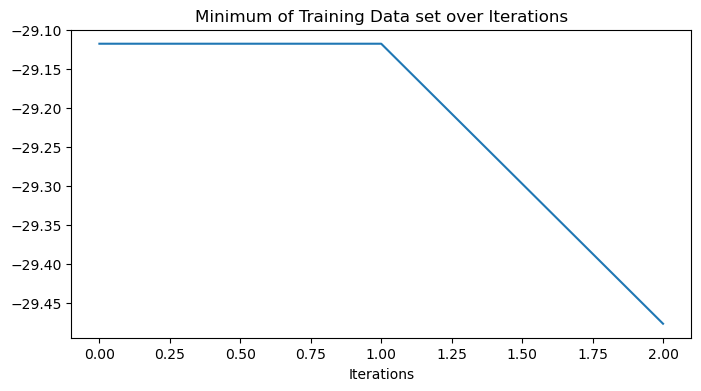

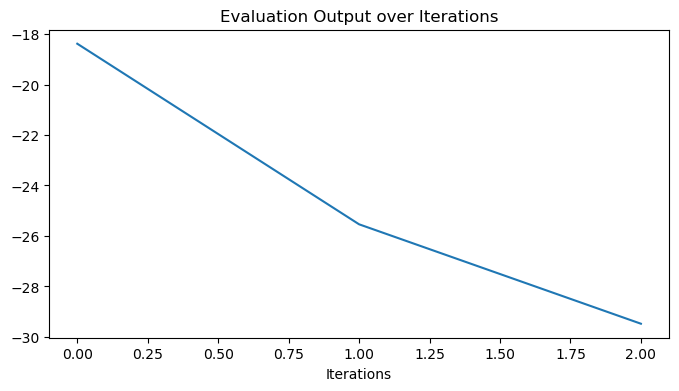

In [11]:
X_initial = np.array([[33, 6.25, 10, 20, 20],
                      [38, 8, 20, 10, 20],
                      [37, 6.8, 0, 50, 0],
                      [36, 6.0, 20, 20, 10],
                      [36.3, 6.0, 20, 20, 10],
                      [28.1, 7.4, 33, 0, 17],
                      [29, 8.5, 15, 10, 25],
                    ])

y_initial = vl.conduct_experiment(X_initial)

temp = np.linspace(30,40,5)
pH = np.linspace(6, 8, 5)
f1 = np.linspace(0, 50, 5)
f2 = np.linspace(0, 50,5)
f3 = np.linspace(0, 50,5)
fidelity = [0,1,2]

X_searchspace     = np.array([[a,b,c,e,d] for a in temp for b in pH for c in f1 for d in f2 for e in f3 ])


def obj_func(X):
	return (-np.array(vl.conduct_experiment(X)))

BO(X = X_initial,  
   kernel = 'SquaredExponential', 
   X_searchspace = X_searchspace, 
   iterations = 3, 
   aquisition_function = 'LCB', 
   objective_func = obj_func, 
   print_graph = True, 
   aquisition_hyperparam=[3])